In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time


## VS Code, choisir un seul des 3 :

# Pour affichage interactif (notamment 3D) dans notebook
# %matplotlib widget

# Pour affichage interactif (notamment 3D) dans une fenêtre qt externe au notebook
# %matplotlib qt

# Pour affichage simple dans notebook
%config InlineBackend.figure_format = 'png'

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv')
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'day', 'hashed_partner_id',
       'hashed_campaign_id', 'contextid', 'display_env', 'target_env',
       'rtbtypeid', 'rtbadvisibility', 'rtb_detectedlanguage', 'urlhash2',
       'urlhash3', 'urlhash4', 'user_country', 'hashed_affiliateid',
       'hashed_app_id', 'googleviewability', 'googlepagevertical',
       'campaignscenario', 'campaignvertical', 'campaignctrlast24h',
       'is_interstitial', 'dayssincelastvisitdouble',
       'ltf_lastpartnerclicktimestamp', 'ltf_nbglobalclick_4w',
       'ltf_nbglobaldisplay_4w',
       'ltf_nbglobaldisplaysincelastpartnerproductview',
       'ltf_nbpartnerdisplayssincelastclick', 'ltf_nbpartnerclick_4w',
       'ltf_nbpartnerdisplay_4w', 'ltf_nbpartnersales_4w',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplaypartnerapprox_1d_sum_xdevice',
       'nbdisplayaffiliateapprox_1d_sum_xdevice',
       'nbd

In [3]:
# Shuffling
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
# On enlève des variables ltf grâce aux corrélations visibles dans la matrice. 
df_acp = df[['contextid','dayssincelastvisitdouble','campaignctrlast24h','nbdisplay_1hour','nbdayssincelastclick','display_size','ltf_nbpartnerdisplayssincelastclick','ltf_nbglobaldisplay_4w','ltf_nbpartnerclick_4w','ltf_nbpartnerdisplay_4w','ltf_nbpartnersales_4w','nbdisplayglobalapprox_1d_sum_xdevice','is_display_clicked']]
df_acp = df_acp.dropna().reset_index(drop=True)

In [5]:
colors = np.array(['r' if (df_acp['is_display_clicked'][i] == 0) else 'g' for i in range(len(df_acp))])
df_acp = df_acp.drop(['is_display_clicked'], axis=1)

In [6]:
len(df_acp)/len(df)

1.0

In [7]:
sc = StandardScaler()
Z = sc.fit_transform(df_acp)
Z

array([[-0.67917548, -0.42204781,  1.64362124, ..., -0.07788934,
        -0.01389272, -0.66581735],
       [-1.92104218, -0.44867976, -0.35161468, ..., -0.07788934,
        -0.01389272,  3.45666087],
       [-0.67917548, -0.41809873, -0.32820149, ..., -0.07788934,
        -0.01389272, -0.43140329],
       ...,
       [-0.67917548, -0.42733918, -0.26563883, ..., -0.07788934,
        -0.01389272, -0.60585479],
       [ 0.97664678, -0.39057191, -0.61142932, ..., -0.07788934,
        -0.01389272,  0.21200611],
       [ 1.39060235, -0.39271181, -0.40109004, ..., -0.07788934,
        -0.01389272, -0.5009203 ]])

In [8]:
acp = PCA(svd_solver='full')

In [9]:
# Calcul des coordonnées factorielles
coord = acp.fit_transform(Z)
# Vérification du nombre de composantes principales
print(acp.n_components_)

12


In [10]:
print(acp.explained_variance_ratio_)

[0.19421456 0.10651577 0.10082156 0.09315579 0.08545678 0.08311288
 0.07358531 0.07040916 0.06698091 0.05946111 0.0444153  0.02187087]


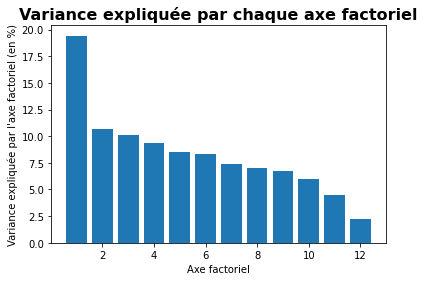

In [11]:
plt.figure(figsize=(6,4))
plt.bar(np.arange(1,acp.n_components_+1),acp.explained_variance_ratio_*100)
plt.title("Variance expliquée par chaque axe factoriel", size=16, fontweight='bold')
plt.ylabel("Variance expliquée par l'axe factoriel (en %)", size=10)
plt.xlabel("Axe factoriel", size=10)
plt.show()

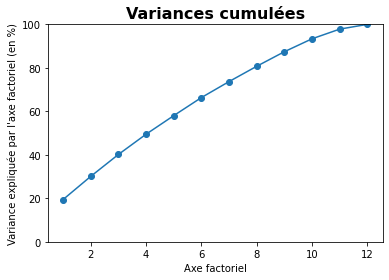

In [12]:
plt.figure(figsize=(6,4))
plt.plot(np.arange(1,acp.n_components_+1),acp.explained_variance_ratio_.cumsum()*100,  marker = 'o')
plt.title("Variances cumulées", size=16, fontweight='bold')
plt.ylim(0, 100)
plt.ylabel("Variance expliquée par l'axe factoriel (en %)", size=10)
plt.xlabel("Axe factoriel", size=10)
plt.show()

In [13]:
coord_not_cliqued = [ [] for _ in range(acp.n_components_)]
coord_cliqued = [ [] for _ in range(acp.n_components_)]

for i in range(len(coord[:,0])):
    if df['is_display_clicked'][i] == 0:
        for j in range(acp.n_components_):
            coord_not_cliqued[j].append(coord[i,j])
    else:
        for j in range(acp.n_components_):
            coord_cliqued[j].append(coord[i,j])

In [14]:
def affichage_plan_factoriel_equal(i, j, pourcentage=1, equal=False, markersize=0.75, verbose=False):
    """
    pourcentage: proprotion de points à afficher
    equal: si True, autant de points rouges que de points verts
    """
    plt.figure(figsize=(6,4))

    if not equal:
        N_not = int(1/pourcentage)
        N = int(1/pourcentage)   

    if equal:
        coeff = len(coord_cliqued[0]) / len(coord_not_cliqued[0])
        N_not = int(1/(pourcentage*coeff))
        N = int(1/pourcentage)

       # N_not = int(1/pourcentage)
       # N = int(coeff/pourcentage)

    if verbose:
        print(f"N_not : {N_not}")
        print(f"N : {N}")
        print(f"Nombre de points rouges : {len(coord_not_cliqued[0][::N_not])}")
        print(f"Nombre de points verts : {len(coord_cliqued[0][::N])}")

    plt.plot(coord_not_cliqued[i-1][::N_not], coord_not_cliqued[j-1][::N_not], '.', color='r', linestyle="None", markersize=markersize)
    plt.plot(coord_cliqued[i-1][::N], coord_cliqued[j-1][::N], '.', color='g', linestyle="None", markersize=markersize)
    plt.xlabel(f'Axe {i}')
    plt.ylabel(f'Axe {j}')
    plt.title(f'Plan (Axe {i}, Axe {j})')
    plt.legend(['Pas cliqué', 'Cliqué'])
    # plt.savefig('plan_axe1_axe2.png', dpi = 500, bbox_inches='tight', figsize=(10,6))
    # plt.close()
    plt.show()

def affichage_plan_factoriel(i,j):
    plt.figure(figsize=(6,4))
    plt.xlabel(f'Axe {i}')
    plt.ylabel(f'Axe {j}')
    plt.title(f'Plan (Axe {i}, Axe {j})')
    plt.scatter(coord[:,i-1], coord[:,j-1], c=colors, marker=".", s=0.75)
    plt.show()

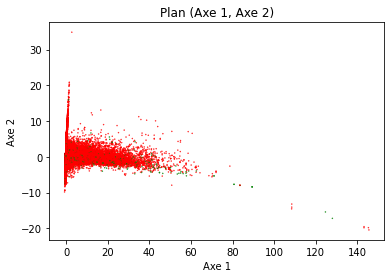

In [15]:
affichage_plan_factoriel(1, 2)

N_not : 82
N : 5
Nombre de points rouges : 18522
Nombre de points verts : 18351


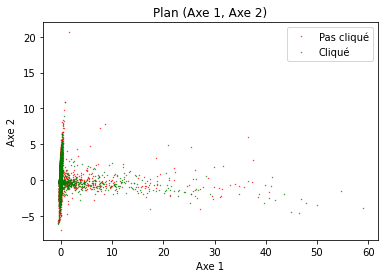

In [16]:
affichage_plan_factoriel_equal(1, 2, pourcentage=0.2, equal=True, verbose=True)

In [17]:
# On supprime les observations marginales
axe1 = np.array(coord[:,0])
df_acp.drop(df_acp.index[axe1 > 115], inplace=True)
colors = colors[axe1 <= 115]

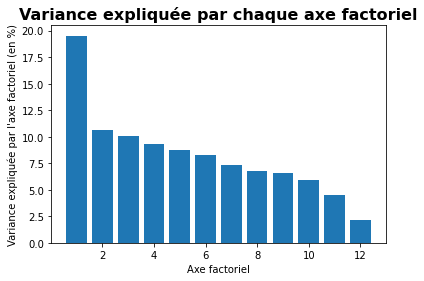

In [18]:
sc = StandardScaler()
Z = sc.fit_transform(df_acp)
acp = PCA(svd_solver='full')
coord = acp.fit_transform(Z)
plt.figure(figsize=(6,4))
plt.bar(np.arange(1,acp.n_components_+1),acp.explained_variance_ratio_*100)
plt.title("Variance expliquée par chaque axe factoriel", size=16, fontweight='bold')
plt.ylabel("Variance expliquée par l'axe factoriel (en %)", size=10)
plt.xlabel("Axe factoriel", size=10)
plt.show()

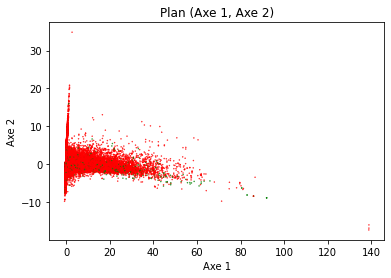

In [19]:
affichage_plan_factoriel(1, 2)

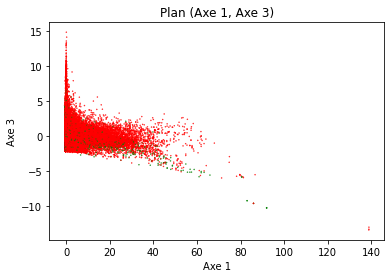

In [20]:
affichage_plan_factoriel(1, 3)

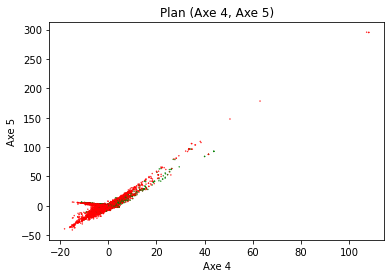

In [21]:
affichage_plan_factoriel(4,5)

In [22]:
n = len(df_acp)
p = len(df_acp.columns)

eigval = (n-1)/n*acp.explained_variance_
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

In [23]:
def affichage_cercle_corr(ax1, ax2):
    fig, axes = plt.subplots(figsize=(5,5))
    axes.set_xlim(-1.05, 1.05)
    axes.set_ylim(-1.05, 1.05)

    for j in range(p):
        axes.arrow(0, 0, corvar[j,ax1], corvar[j,ax2], head_width=0.005, head_length=0.01, fc='grey', ec='grey')
        plt.annotate(df_acp.columns[j], (corvar[j,ax1],corvar[j,ax2]), size=8, color='r')

    plt.plot([-1, 1], [0, 0],color='silver', linestyle='-', linewidth=1)
    plt.plot([0, 0], [-1, 1],color='silver', linestyle='-', linewidth=1)

    cercle = plt.Circle((0, 0), 1, color='blue', fill=False)
    axes.add_artist(cercle)

    plt.show()

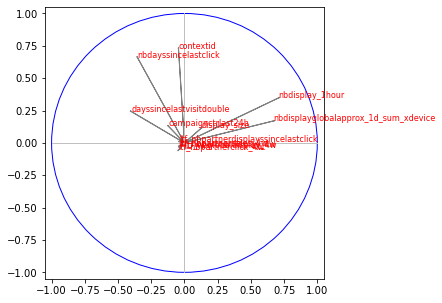

In [24]:
affichage_cercle_corr(1,2)

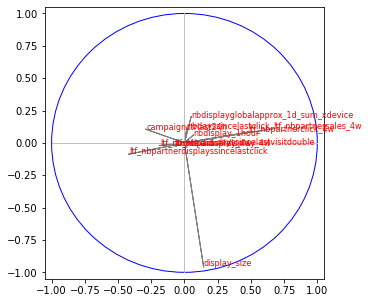

In [25]:
affichage_cercle_corr(4,5)

In [26]:
print(pd.Series(coord_cliqued[3]).describe(), '\n')
print(pd.Series(coord_not_cliqued[3]).describe())

count    91752.000000
mean         0.479536
std          1.278250
min        -11.769109
25%         -0.193119
50%          0.240426
75%          1.191703
max         60.189918
dtype: float64 

count    1.518742e+06
mean    -2.897031e-02
std      1.035357e+00
min     -1.556756e+01
25%     -5.023613e-01
50%     -9.316019e-02
75%      3.572699e-01
max      5.298924e+01
dtype: float64


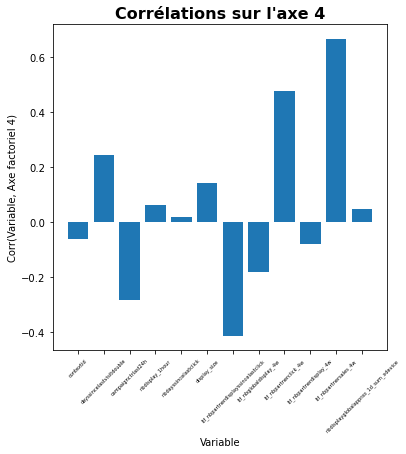

In [27]:
plt.figure(figsize=(6,6))
plt.rc('xtick', labelsize=5)
plt.xticks(rotation=45)
plt.bar(np.arange(1,acp.n_components_+1), corvar[:,4], tick_label=df_acp.columns)
plt.title("Corrélations sur l'axe 4", size=16, fontweight='bold')
plt.ylabel("Corr(Variable, Axe factoriel 4)", size=10)
plt.xlabel("Variable", size=10)
plt.show()

In [28]:
def affichage_3d_factoriel(i, j, k, pourcentage=1, equal=False, markersize=1, verbose=False):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    if not equal:
        N_not = int(1/pourcentage)
        N = int(1/pourcentage)
    
    if equal:
        coeff = len(coord_cliqued[0]) / len(coord_not_cliqued[0])

        N_not = int(1/(pourcentage*coeff))
        N = int(1/pourcentage)

        # N_not = int(1/pourcentage)
        # N = int(coeff/pourcentage)

    if verbose:
        print(f"N_not : {N_not}")
        print(f"N : {N}")
        print(f"Nombre de points rouges : {len(coord_not_cliqued[0][::N_not])}")
        print(f"Nombre de points verts : {len(coord_cliqued[0][::N])}")

    ax.scatter(coord_not_cliqued[i-1][::N_not], coord_not_cliqued[j-1][::N_not], coord_not_cliqued[k-1][::N_not], s=markersize, color='r', linestyle="None", marker='o')
    ax.scatter(coord_cliqued[i-1][::N], coord_cliqued[j-1][::N], coord_cliqued[k-1][::N], s=markersize, color='g', linestyle="None", marker='o')
    ax.set_xlabel(f'Axe {i}')
    ax.set_ylabel(f'Axe {j}')
    ax.set_zlabel(f'Axe {k}')
    plt.title(f'Plan (Axe {i}, Axe {j}, Axe {k})')
    plt.legend(['Pas cliqué', 'Cliqué'])
    plt.show()

N_not : 1655
N : 100
Nombre de points rouges : 918
Nombre de points verts : 918


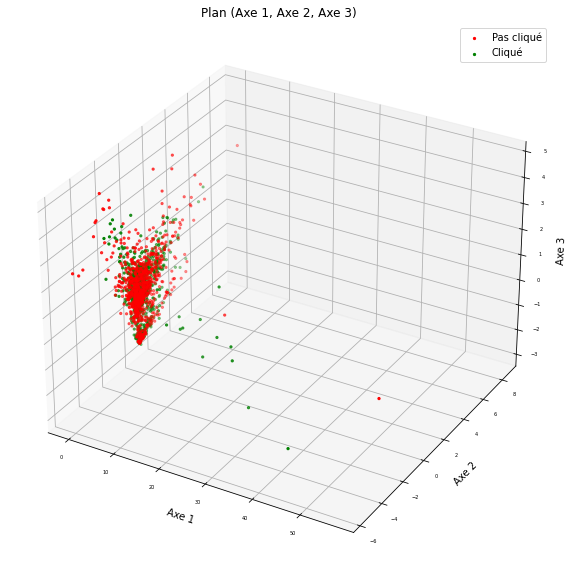

In [29]:
affichage_3d_factoriel(1, 2, 3, pourcentage=0.01, equal=True, markersize=5, verbose=True)

In [30]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:02:16
